In [1]:
import domain_adapt_run.domain_adapt_run.constants as constants
cache_folder_name = 'KMM_weighted_kernel_sufficient_dimension_reduction_cleaned_more'
seed = 44

In [2]:
import autograd.numpy as np
np.random.seed(seed)
import python_utils.python_utils.basic as basic
import python_utils.python_utils.caching as caching
log_folder = '%s/%s' % (constants.cache_folder, cache_folder_name)
caching.init(constants.cache_folder, constants.which_hash, basic.archiver(log_folder))
%load_ext autoreload
%autoreload 2

[Errno 17] File exists: '/Users/fultonw/Documents/projects/runs/domain_adapt_run/cache/KMM_weighted_kernel_sufficient_dimension_reduction_cleaned_more'


In [3]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display_pretty, display_html
import python_utils.python_utils.basic as basic
import pandas as pd
import pdb
import itertools
import functools
import scipy.stats, scipy
import cvxopt
import domain_adapt.domain_adapt.kernels as kernels
import pymanopt
import pprint, autograd

Couldn't import dot_parser, loading of dot files will not be possible.


## define data

In [4]:
# u is subspace where features differ.  v is subspace on which y is determined 
x_dim = 2
u_dim = 1
v_dim = 1
y_dim = 1
u_perp_dim = x_dim - u_dim
u_bases = kernels.ortho(np.array([[1.,0.]]).T)
u_perp_bases = kernels.ortho(np.array([[0.,1.]]).T)
u_all_bases = np.hstack((u_bases, u_perp_bases))
v_perp_dim = x_dim - v_dim
v_bases = kernels.ortho(np.array([[0.,1.]]).T)
v_perp_bases = kernels.ortho(np.array([[1.,0.]]).T)

In [5]:
# define train u distribution
p_u_train_dist = scipy.stats.multivariate_normal(mean=np.zeros(shape=u_dim))
p_u_train_pdf = p_u_train_dist.pdf
p_u_train_sample = p_u_train_dist.rvs

In [6]:
# define test u distribution
p_u_test_dist = scipy.stats.multivariate_normal(mean=np.zeros(shape=u_dim)+7.)
p_u_test_pdf = p_u_test_dist.pdf
p_u_test_sample = p_u_test_dist.rvs

In [7]:
# define shared u_perp distribution
p_u_perp_dist = scipy.stats.multivariate_normal(mean=np.zeros(shape=u_perp_dim))
p_u_perp_pdf = p_u_test_dist.pdf
p_u_perp_sample = p_u_test_dist.rvs

In [8]:
# define p given v
f_v = lambda v: 1*np.ones(u_dim).dot(v)
y_var = 0.002
p_y_noise_sample = scipy.stats.multivariate_normal(mean=np.zeros(shape=y_dim),cov=np.eye(y_dim)*y_var).rvs
p_y_given_v_sample = lambda v: f_v(v) + p_y_noise_sample()

In [9]:
# specify number of data to generate
num_train = 50
num_test = 50

In [10]:
# generate data
expand = lambda s: s.reshape(len(s),1) if len(s.shape) == 1 else s
us_train = expand(np.array([p_u_train_sample() for i in xrange(num_train)]))
us_test = expand(np.array([p_u_test_sample() for i in xrange(num_test)]))
us_perp_train = expand(np.array([p_u_perp_sample() for i in xrange(num_train)]))
us_perp_test = expand(np.array([p_u_perp_sample() for i in xrange(num_test)]))
xs_train = np.dot(np.hstack((us_train, us_perp_train)), u_all_bases.T)
xs_test = np.dot(np.hstack((us_test, us_perp_test)), u_all_bases.T)
vs_train = np.dot(xs_test, v_bases)
ys_train = np.array([p_y_given_v_sample(v) for v in vs_train])

## plot raw data

In [11]:
# define some constants for plotting
xs_plot_dim_1 = 0
xs_plot_dim_2 = 1
plot_us_train = us_train
P_u = np.zeros((u_dim,1))
P_u[0] = 1.
plot_1d_us_train = plot_us_train.dot(P_u)
plot_ys_train = ys_train
color_wheel = itertools.cycle(['c','b','k','g'])

/Users/fultonw/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


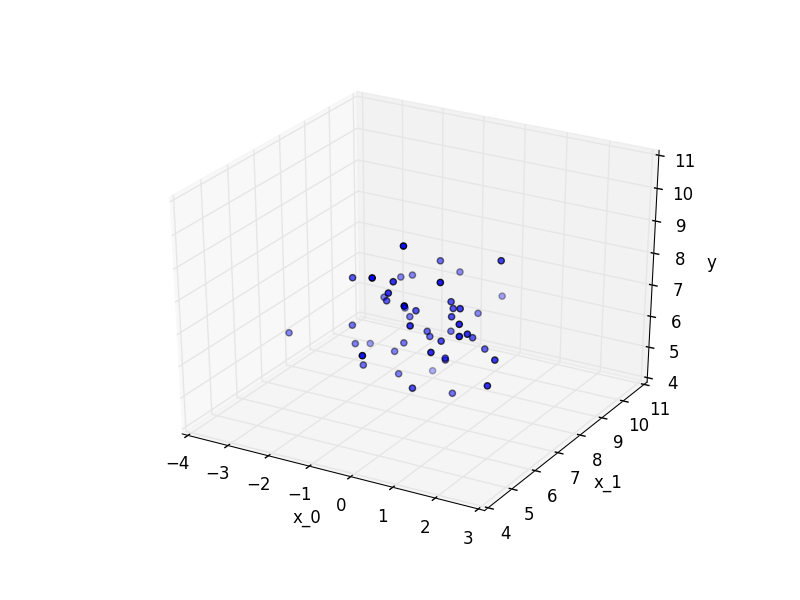

In [12]:
# plot train data, 3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs_train[:,xs_plot_dim_1],xs_train[:,xs_plot_dim_2],ys_train)
ax.set_xlabel('x_%d' % xs_plot_dim_1)
ax.set_ylabel('x_%d' % xs_plot_dim_2)
ax.set_zlabel('y')
basic.display_fig_inline(fig)

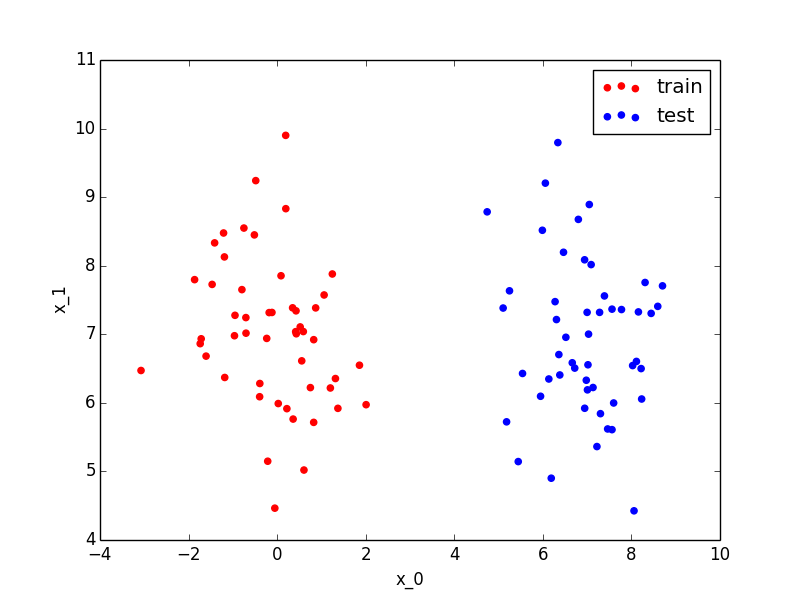

In [13]:
# plot train xs, test xs, 2d
fig, ax = plt.subplots()
ax.scatter(xs_train[:,xs_plot_dim_1],xs_train[:,xs_plot_dim_2], color='r', label='train')
ax.scatter(xs_test[:,xs_plot_dim_1],xs_test[:,xs_plot_dim_2], color='b', label='test')
ax.set_xlabel('x_%d' % xs_plot_dim_1)
ax.set_ylabel('x_%d' % xs_plot_dim_2)
ax.legend()
basic.display_fig_inline(fig)

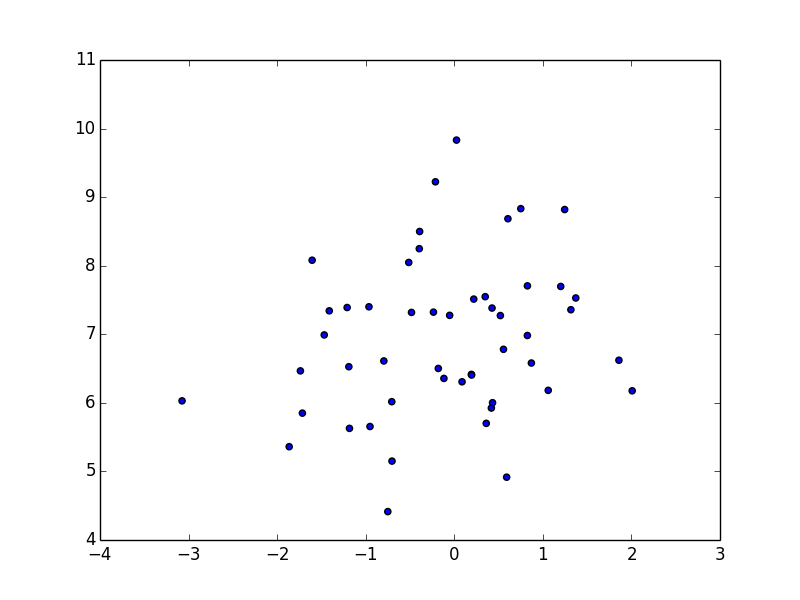

In [14]:
# plot data, 2d
fig, ax = plt.subplots()
ax.scatter(plot_1d_us_train,ys_train)
basic.display_fig_inline(fig)

## define hyperparameters

In [15]:
#
def mat_median(m):
    l = len(m)
    v = np.arange(l).reshape((l,1))
    return np.median(m[v != v.T])

def median_distance(xs1, xs2):
    diff = xs1[:,np.newaxis,:] - xs2[np.newaxis,:,:]
    norms = np.sum(diff * diff, axis=2) ** 0.5
    return mat_median(norms)

In [16]:
# define stuff for SDR
#sigma = 0.1
#sigma = 0.5
sigma = 0.5
SDR_get_K = functools.partial(kernels.get_gaussian_K, sigma)
#get_SDR_get_K = lambda P,step: SDR_get_K
#get_SDR_get_K = lambda P,step: functools.partial(kernels.get_gaussian_K, (0.5**step) * median_distance(np.dot(xs_train,P),np.dot(xs_train,P)))
get_SDR_get_K = lambda P,step: functools.partial(kernels.get_gaussian_K, (0.5**step) * median_distance(np.dot(xs_train,P),np.dot(xs_test,P)))

SDR_get_Ky = lambda P,step: functools.partial(kernels.get_gaussian_K, median_distance(ys_train, ys_train,P))
#get_SDR_get_Ky = lambda P,step: SDR_get_Ky
get_SDR_get_Ky = get_SDR_get_K
SDR_eps = 0.01

In [17]:
# define stuff for KMM
#B_max = 100
B_max = 100
KMM_eps = 0.01
KMM_get_K = SDR_get_K
#get_KMM_get_K = lambda P,step: KMM_get_K
get_KMM_get_K = get_SDR_get_K

In [18]:
# see what bandwidth is like for some random projections
[get_SDR_get_K(kernels.ortho(np.random.uniform(size=(x_dim,v_dim))),0).args[0] for i in xrange(10)]

[7.0004046993362952,
 1.1330025944170266,
 6.5684936135157592,
 3.1540033080519141,
 4.6625925544824405,
 2.1138503919071319,
 1.2460377606193798,
 6.1578882678890512,
 1.3113244449889838,
 1.0321047919337576]

In [19]:
# define objective fxn
tradeoff = 0.1
obj_from_wsopt_and_Ks = lambda Ky, Ku, wsopt: kernels.ws_distance(wsopt)# + (tradeoff * kernels.get_trace_from_ws_and_Ks(SDR_eps, Ky, Ku, None)) # set ws to None here to turn off weighting of SDR

In [20]:
# define linear system solvers
reg_lstsq_solver = lambda A,b: scipy.sparse.linalg.lsmr(A,b)[0]
lstsq_solver = lambda A,b: np.linalg.lstsq(A, b)[0]
cg_solver = lambda A,b: scipy.sparse.linalg.cg(A, b)[0]
#lin_solver = lstsq_solver
#lin_solver = cg_solver
lin_solver = reg_lstsq_solver

In [21]:
# define qp solver
cvxopt_solver = kernels.cvxopt_solver

In [22]:
# define fxn that takes in stuff that changes over iterations
get_obj_and_d_obj_dP = lambda KMM_get_K, SDR_get_K, SDR_get_Ky: kernels.get_obj_and_obj_gradient(KMM_get_K, B_max, KMM_eps, SDR_get_K, SDR_get_Ky, obj_from_wsopt_and_Ks, lin_solver, cvxopt_solver, xs_train, xs_test, ys_train)

In [23]:
#
def plot_optimize(optimize_info):
    kernels.plot_opt_log(optimize_info)

In [24]:
# define optimizer
def optimize(plot_optimize, manifold, solver, obj, dobj_dP, P_init):
    from pymanopt import Problem
    problem = pymanopt.Problem(manifold=manifold, cost=obj, egrad=dobj_dP, verbosity=0)
    P_fit, optimize_info = solver.solve(problem, x=P_init)
    plot_optimize(optimize_info)
    return P_fit, optimize_info
from pymanopt.solvers import SteepestDescent
from pymanopt.manifolds import Stiefel
solver = pymanopt.solvers.SteepestDescent(logverbosity=2)
manifold = pymanopt.manifolds.Stiefel(x_dim, u_dim)
plot_opt_info = lambda opt_log: None
optimizer = functools.partial(optimize, plot_optimize, manifold, solver)

In [25]:
# 
def plot_anneal_step(obj, d_obj_dP, KMM_get_K, SDR_get_K, SDR_get_Ky, P, opt_log):
    kernels.plot_weights(xs_train, xs_test, KMM_get_K, B_max, KMM_eps, P)
    kernels.plot_K(xs_train, xs_train, KMM_get_K, P, 'KMM train train')
    kernels.plot_K(xs_train, xs_test, KMM_get_K, P, 'KMM train test')
    #kernels.plot_K(xs_train, xs_train, SDR_get_K, P, 'SDR train train')
    kernels.gradient_check(obj, d_obj_dP, P)
    kernels.plot_train_vs_test(xs_train, xs_test, P)
    kernels.plot_y_vs_u(xs_train, ys_train, P)
    print 'annealing step P:', opt_log['final_values']['x']

In [26]:
# 
def plot_anneal(anneal_info):
    obj_val, anneal_step_infos = anneal_info
    fig, ax = plt.subplots()
    ax.scatter(range(len(anneal_step_infos)), [anneal_step_info[2].args[0] for anneal_step_info in anneal_step_infos])
    ax.set_title('KMM sigma')
    ax.set_xlabel('annealing step')
    ax.set_ylabel('sigma')
    basic.display_fig_inline(fig)

In [27]:
# 
def anneal(plot_anneal, plot_anneal_step, num_anneals, optimizer, get_KMM_get_K, get_SDR_get_K, get_SDR_get_Ky, get_obj_and_d_obj_dP, P):
    anneal_step_infos = [] # store the things that change
    for step in xrange(num_anneals):
        KMM_get_K = get_KMM_get_K(P,step)
        SDR_get_K = get_SDR_get_K(P,step)
        SDR_get_Ky = get_SDR_get_Ky(P,step)
        obj, d_obj_dP = get_obj_and_d_obj_dP(KMM_get_K, SDR_get_K, SDR_get_Ky)
        
        print 'PRE gradcheck'
        kernels.gradient_check(obj, d_obj_dP, P)
        kernels.plot_weights(xs_train, xs_test, KMM_get_K, B_max, KMM_eps, P)
        kernels.plot_K(xs_train, xs_train, KMM_get_K, P, 'PRE KMM train train')
        kernels.plot_K(xs_train, xs_test, KMM_get_K, P, 'PRE KMM train test')
        
        P, opt_log = optimizer(obj, d_obj_dP, P)
        anneal_step_info = obj, d_obj_dP, KMM_get_K, SDR_get_K, SDR_get_Ky, P, opt_log
        plot_anneal_step(*anneal_step_info)
        anneal_step_infos.append(anneal_step_info)
    anneal_info = (obj(P), anneal_step_infos)
    plot_anneal(anneal_info)
    return P, anneal_info
num_anneals = 1
annealer = functools.partial(anneal, plot_anneal, plot_anneal_step, num_anneals, optimizer, get_KMM_get_K, get_SDR_get_K, get_SDR_get_Ky, get_obj_and_d_obj_dP)

In [28]:
#
def plot_multiples(multiples_info):
    obj_vals = []
    for anneal_info in multiples_info:
        obj_val, anneal_step_infos = anneal_info
        obj, d_obj_dP, KMM_get_K, SDR_get_K, SDR_get_Ky, P, opt_log = anneal_step_infos[-1]
        obj_vals.append(obj_val)
    print 'obj_vals', obj_vals

In [29]:
#
def multiples(plot_multiples, num_trials, annealer, P_shape):
    trial_infos = []
    best_P = None
    best_obj_val = None
    for i in xrange(num_trials):
        P_init = kernels.ortho(np.random.normal(size=P_shape))
        P, anneal_info = annealer(P_init)
        trial_infos.append(anneal_info)
        (obj_val, anneal_step_infos) = anneal_info
        if best_P is None or obj_val < best_obj_val:
            best_P = P
            best_obj_val = obj_val
    multiples_info = trial_infos
    plot_multiples(multiples_info)

PRE gradcheck
numerical gradient:
[[ -2.25153229e-07]
 [  6.31383834e-07]]
analytical gradient:
num_tight: 50
solver error: 8.41541752849e-07
[[  5.05671510e-07]
 [  5.60763125e-08]]


/Users/fultonw/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/autograd/core.py:37: UserWarning: Output seems independent of input. Returning zero gradient.
  warnings.warn("Output seems independent of input. Returning zero gradient.")


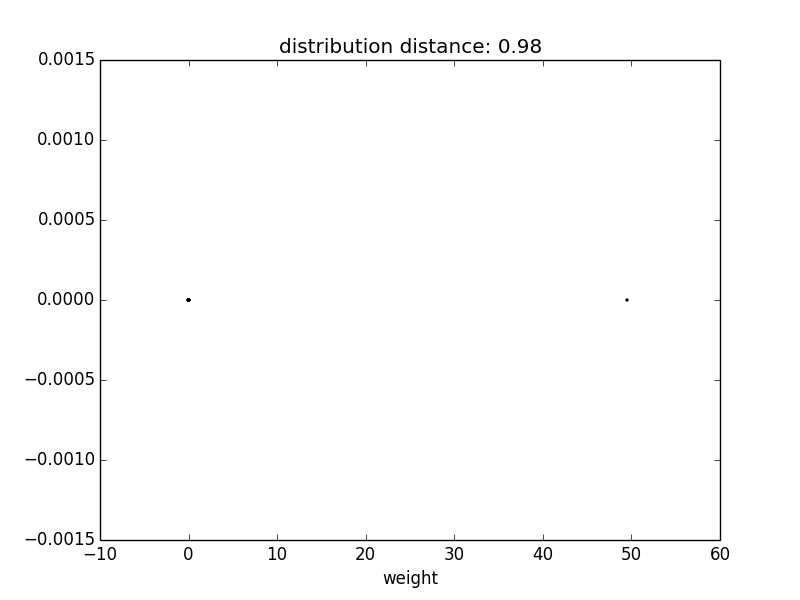

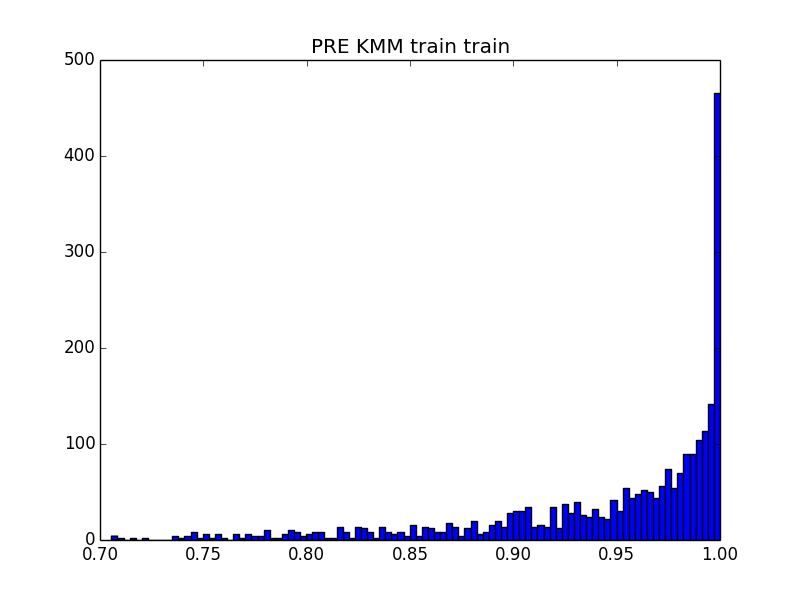

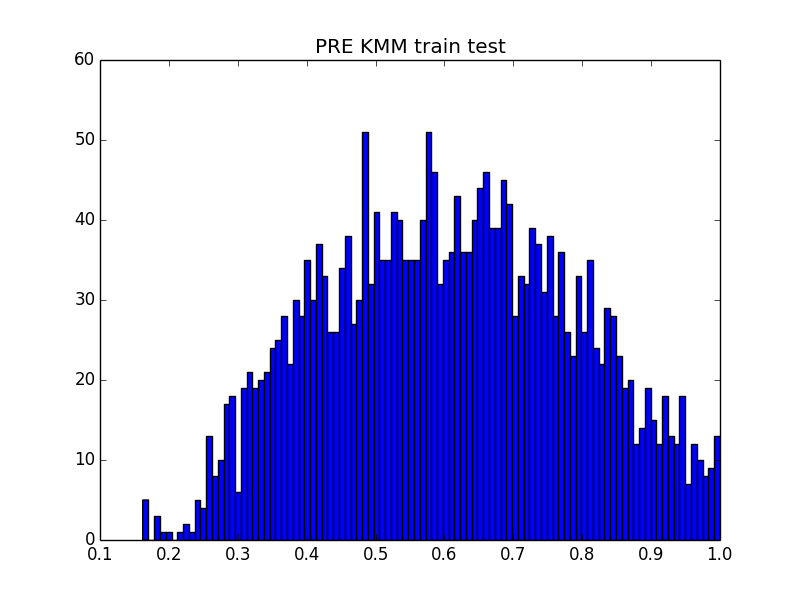

num_tight: 50
solver error: 8.41541752831e-07


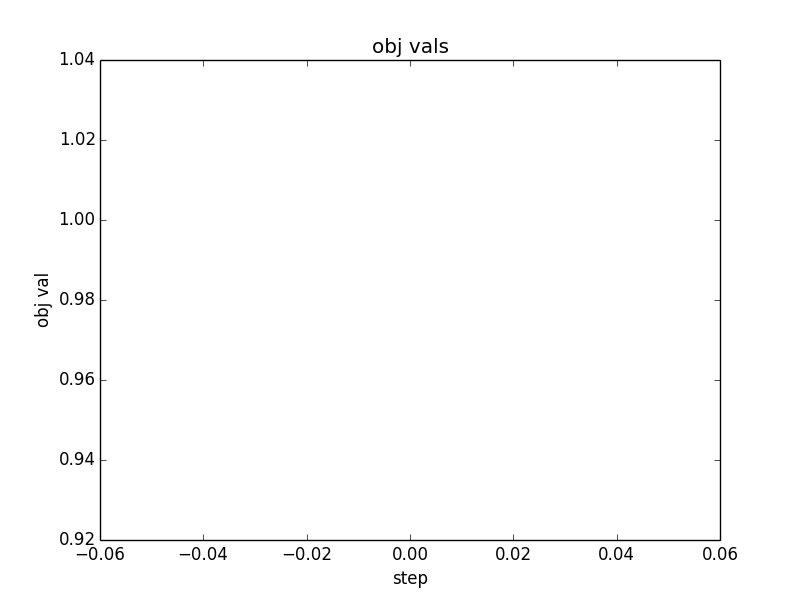

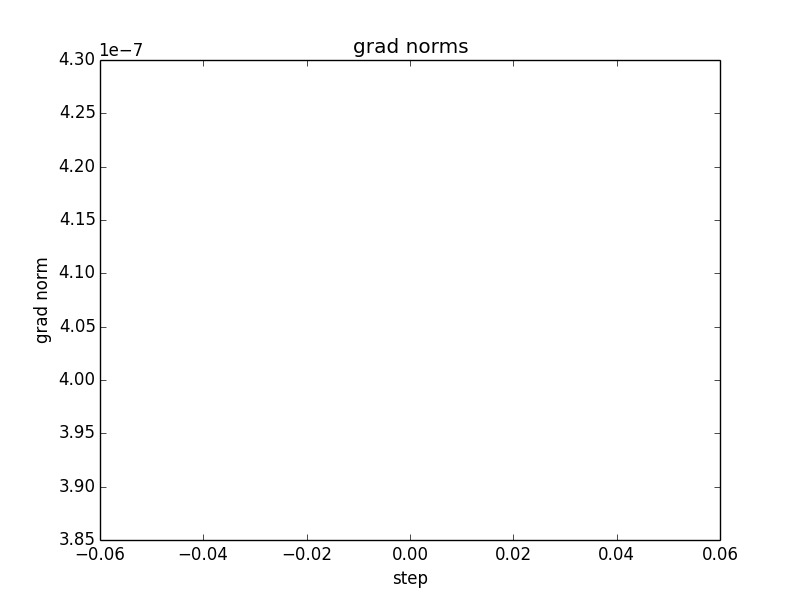

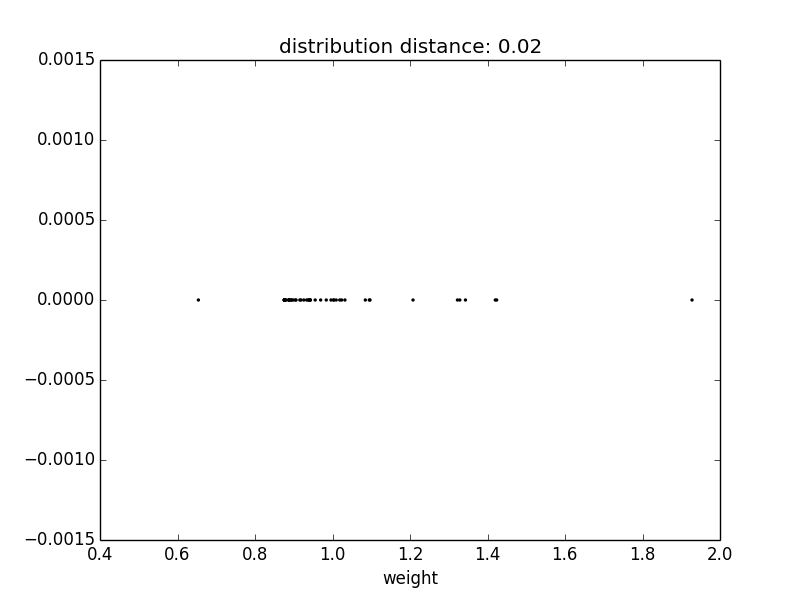

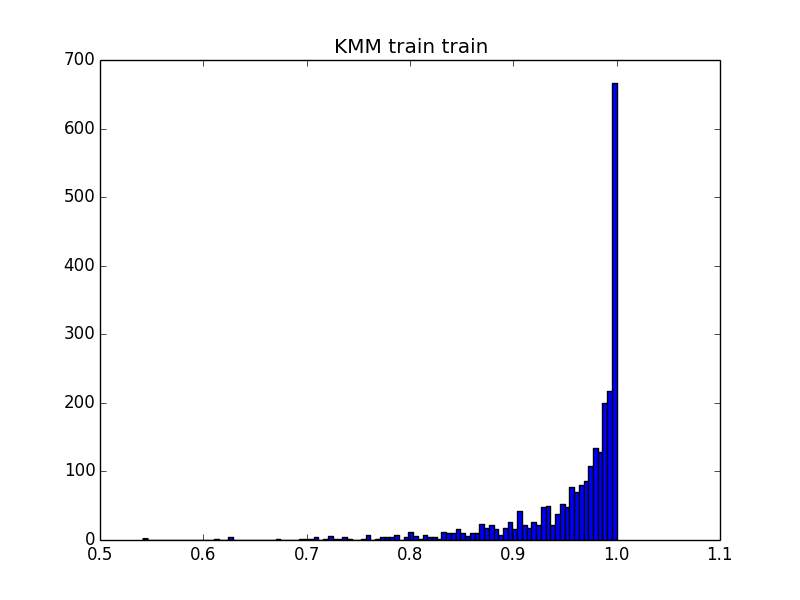

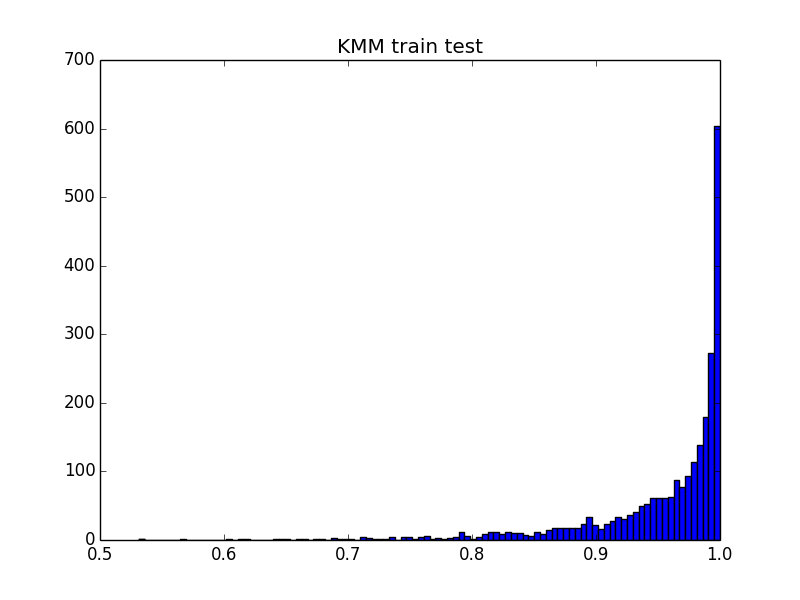

numerical gradient:
[[-0.03609274]
 [ 0.00111631]]
analytical gradient:
num_tight: 0
solver error: 0.000770114351416
[[-0.03354484]
 [ 0.00103188]]


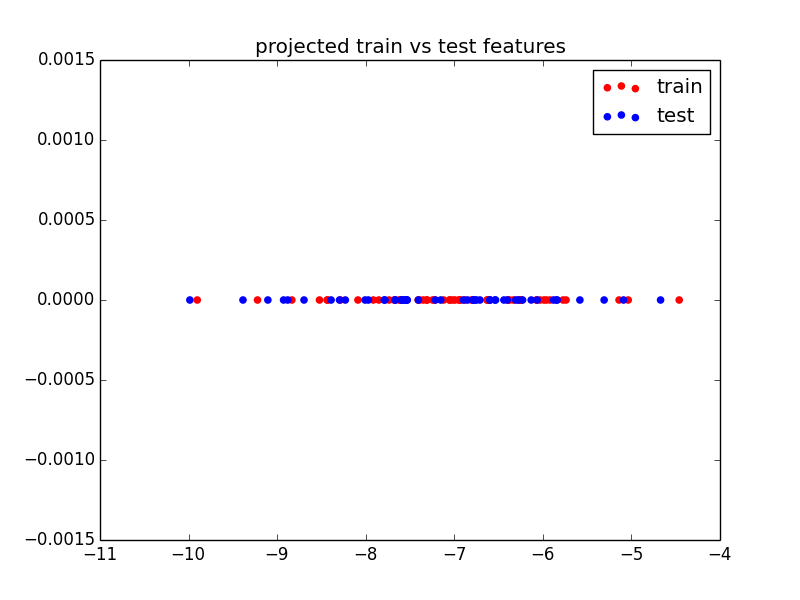

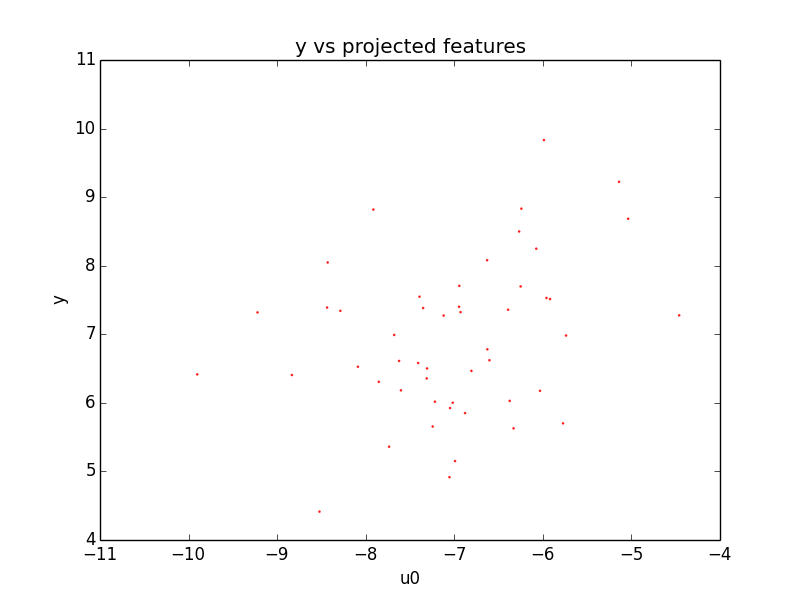

annealing step P: [[-0.03070314]
 [-0.99952855]]


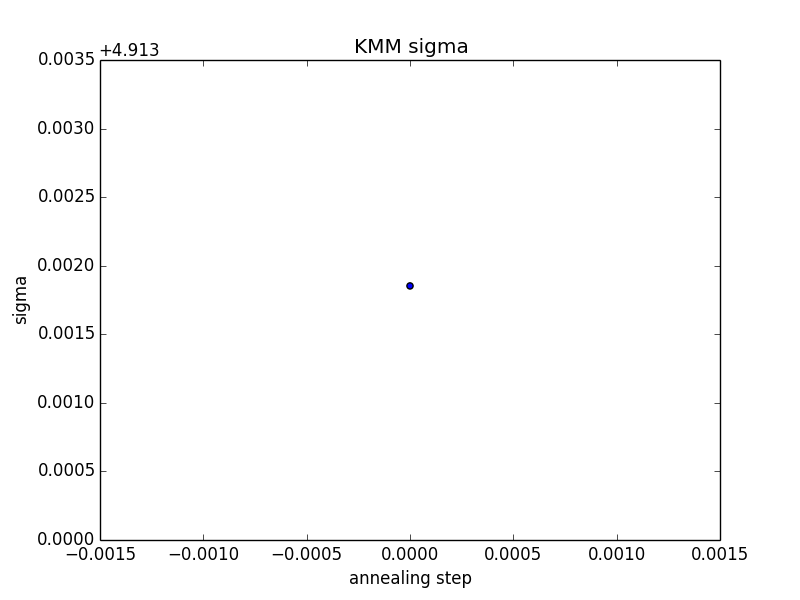

PRE gradcheck
numerical gradient:
[[ -5.97555339e-06]
 [  4.34297043e-06]]
analytical gradient:
num_tight: 50
solver error: 1.20726415956e-06
[[ -1.79042207e-06]
 [  6.45822197e-07]]


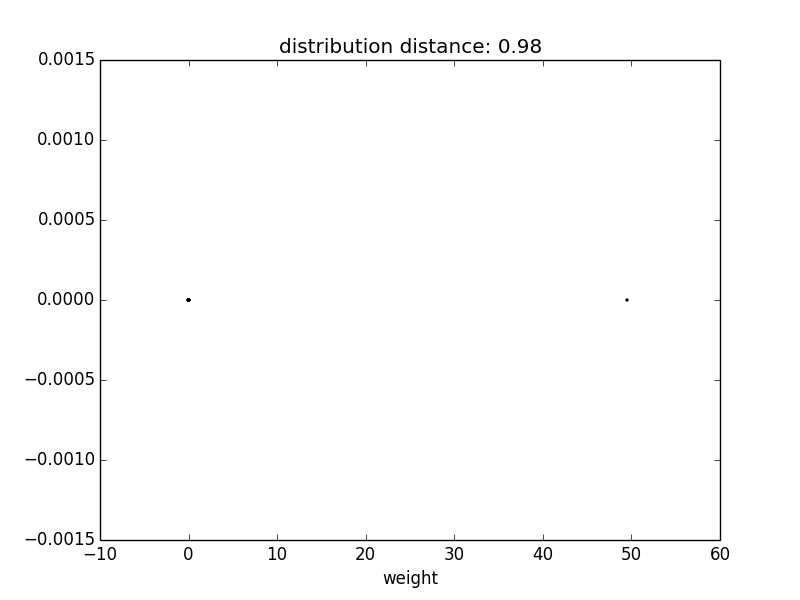

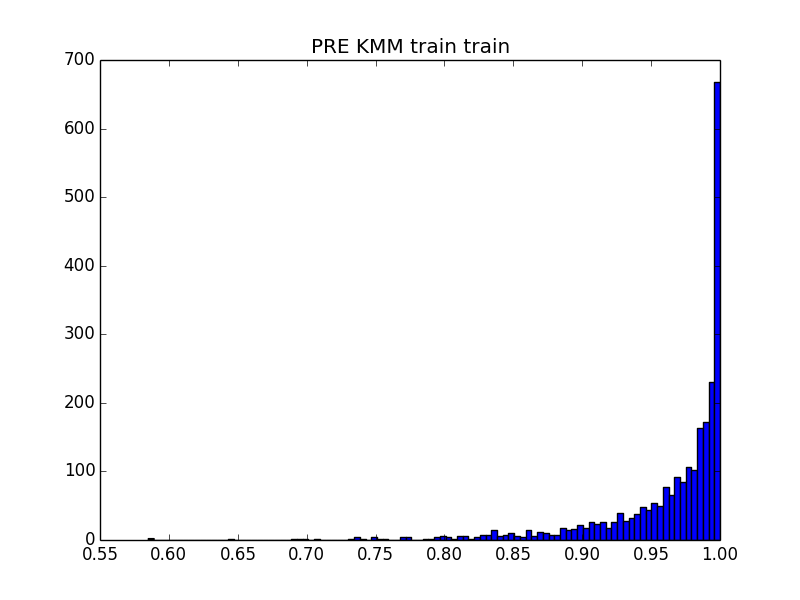

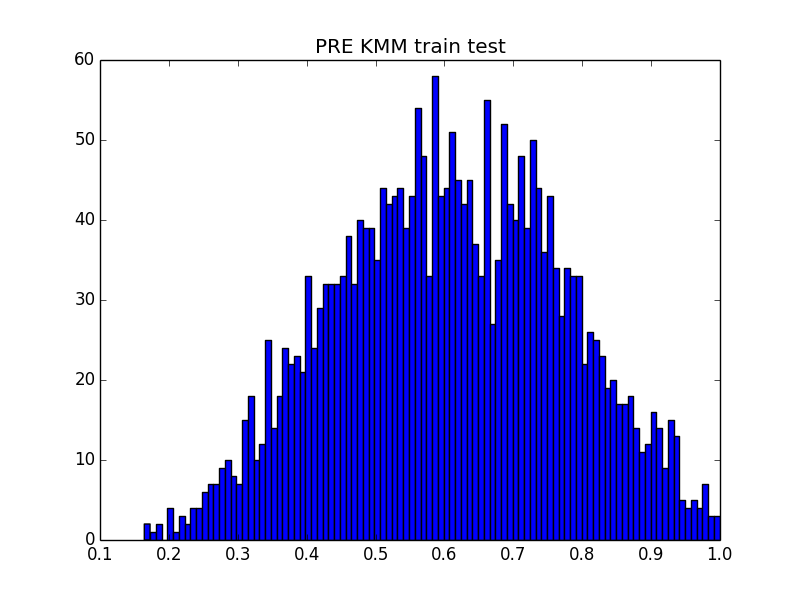

num_tight: 50
solver error: 1.20726415953e-06
num_tight: 0
solver error: 0.000367295171947
num_tight: 0
solver error: 0.000510991579563
num_tight: 0
solver error: 0.000561923932116
num_tight: 0
solver error: 0.000356688340111
num_tight: 0
solver error: 0.000264046564333
num_tight: 0
solver error: 0.000258731061389


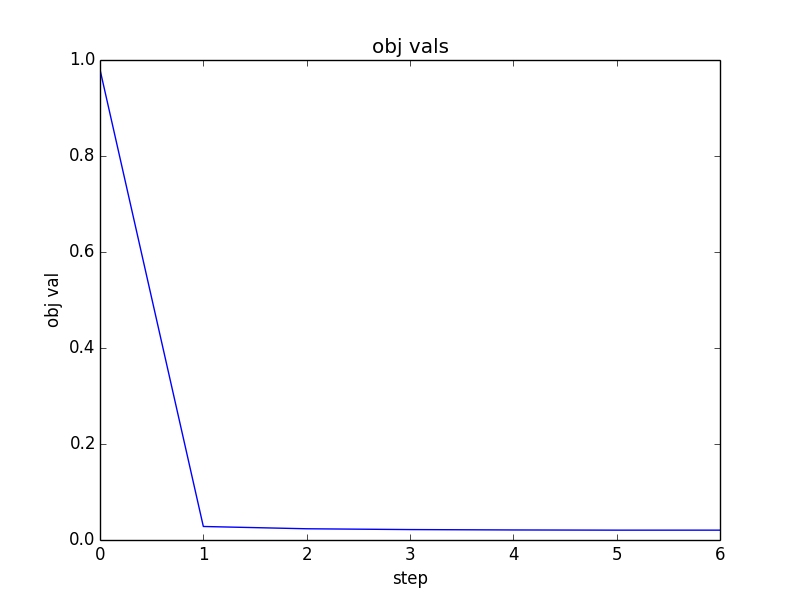

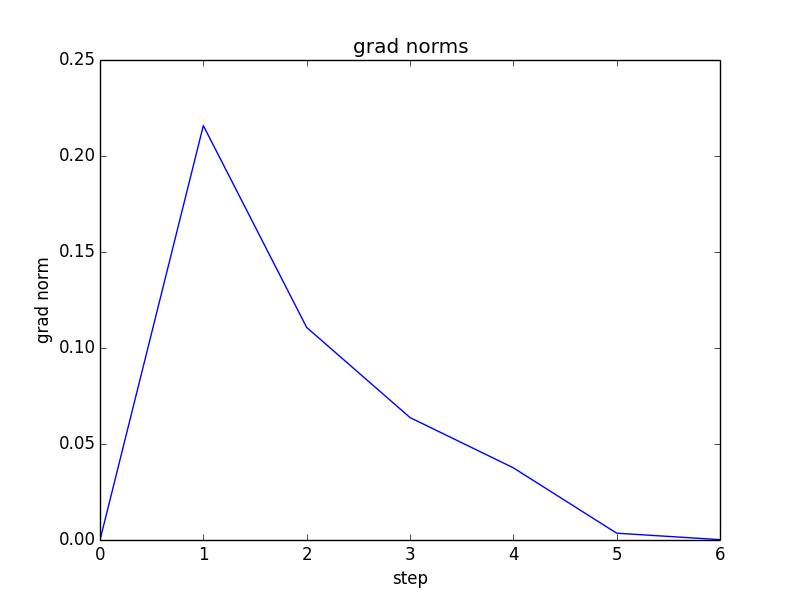

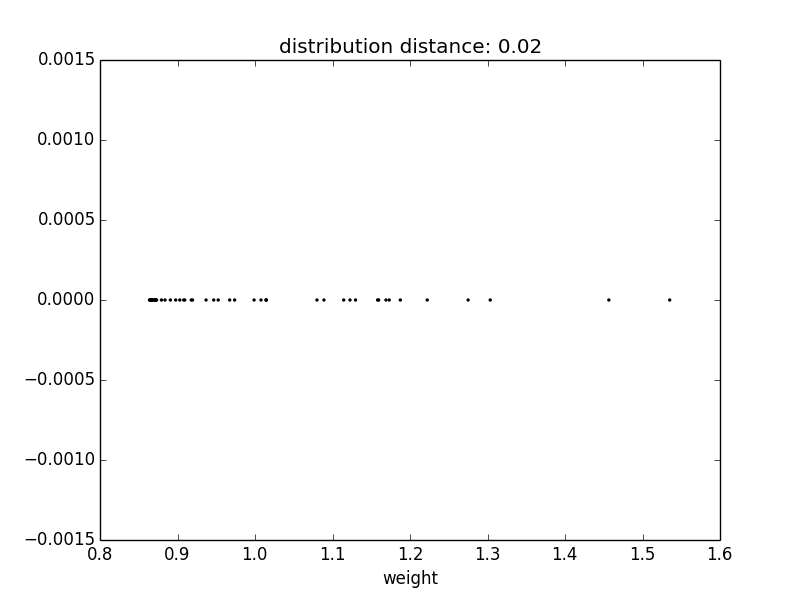

/Users/fultonw/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/pyplot.py:412: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_num_figures`).
  max_open_warning, RuntimeWarning)


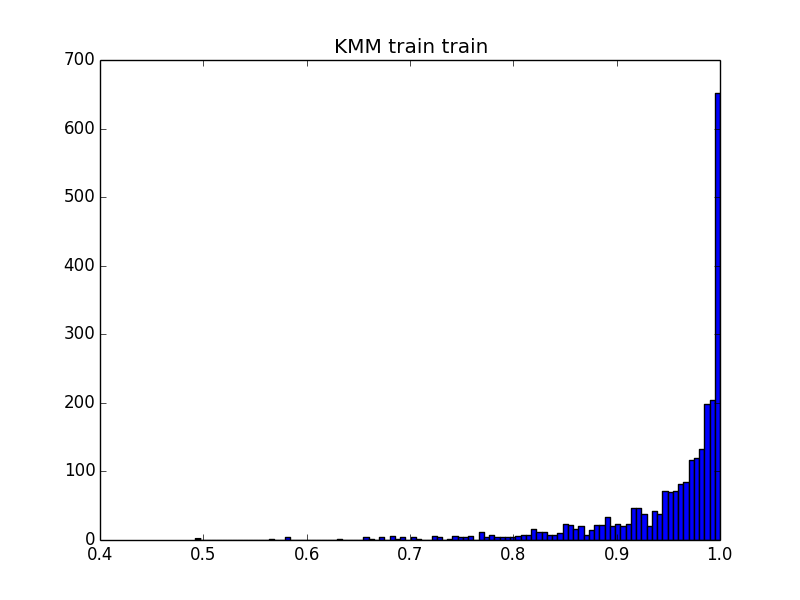

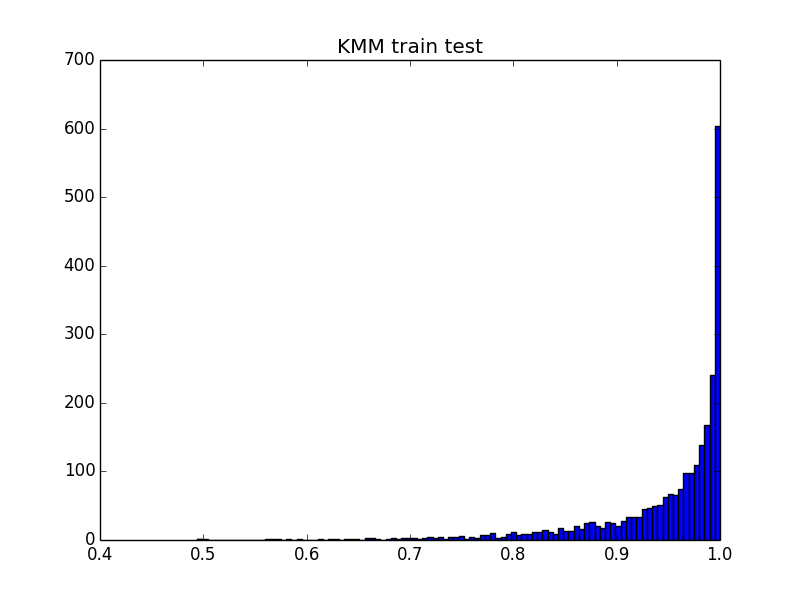

numerical gradient:
[[-0.00292264]
 [-0.00013597]]
analytical gradient:
num_tight: 0
solver error: 0.000258731061439
[[  1.81479670e-04]
 [ -9.32792746e-05]]


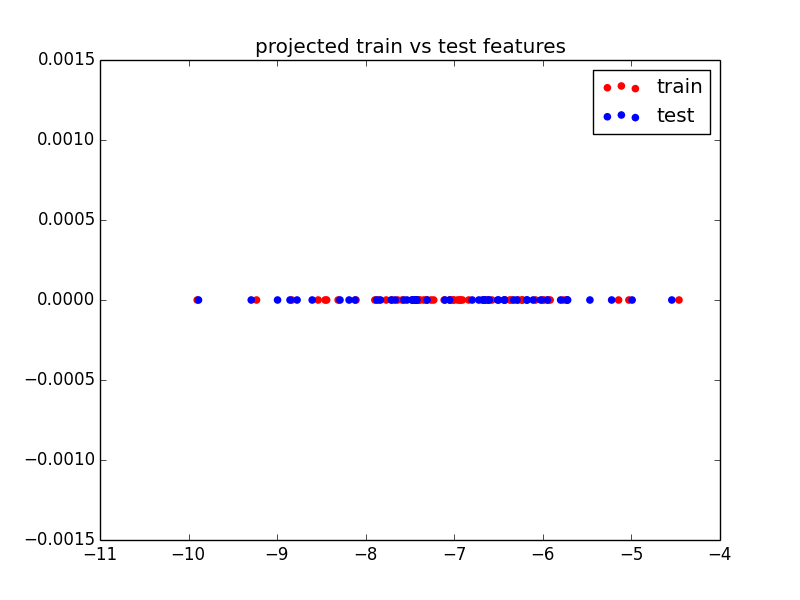

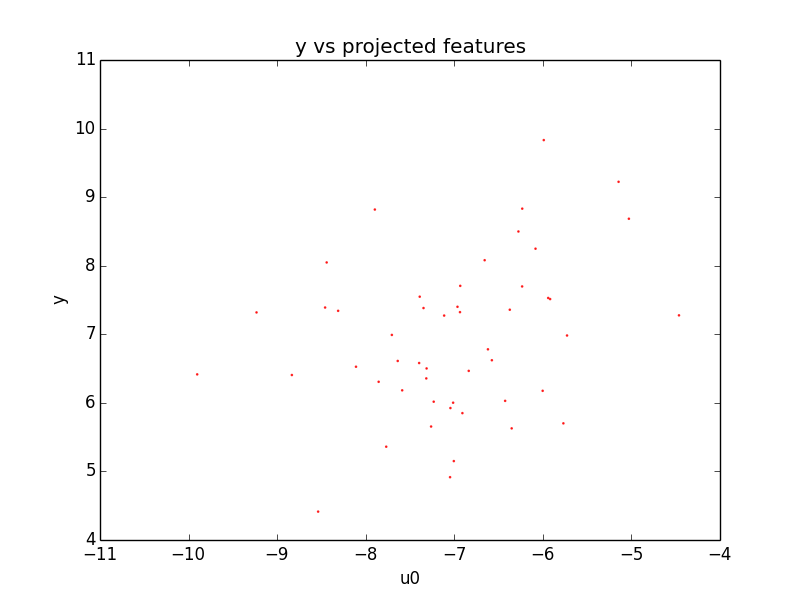

annealing step P: [[-0.0147526 ]
 [-0.99989117]]


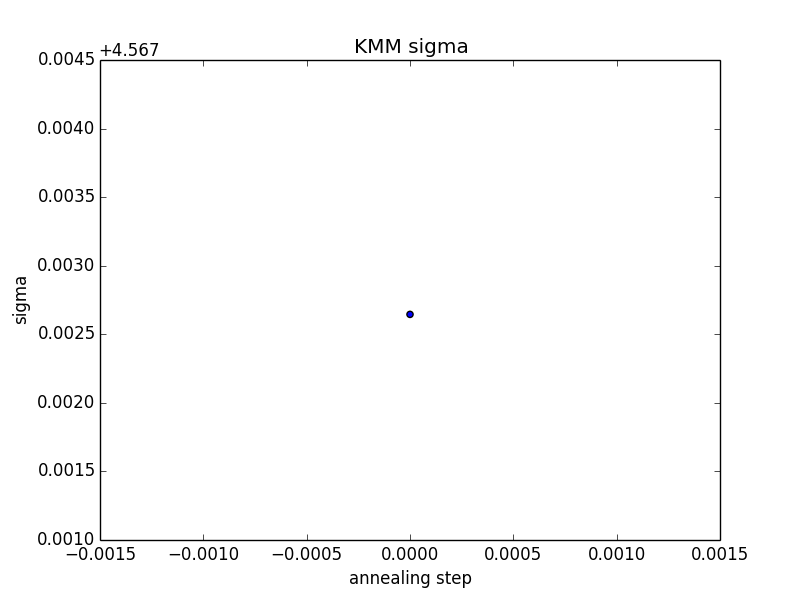

obj_vals [0.020818820581049228, 0.020518296468989606]


In [30]:
#
multiples(plot_multiples, 2, annealer, (x_dim,v_dim))

In [31]:
# define P_init
#P_init = kernels.ortho(np.random.normal(size=(x_dim,v_dim)))
#P_init = kernels.ortho(np.array([[1.,0.]]).T)
#P_init = kernels.ortho(np.array([[1,-2.3]]).T)
#P_init = kernels.ortho(np.array([[0.,1.]]).T)
P_init = kernels.ortho(np.array([[0.19839015,0.98012313]]).T)

PRE gradcheck
numerical gradient:
[[-14.62785826]
 [  6.30428472]]
analytical gradient:
num_tight: 0
solver error: 0.0181306208606
[[ 1.8645135 ]
 [-0.53514991]]


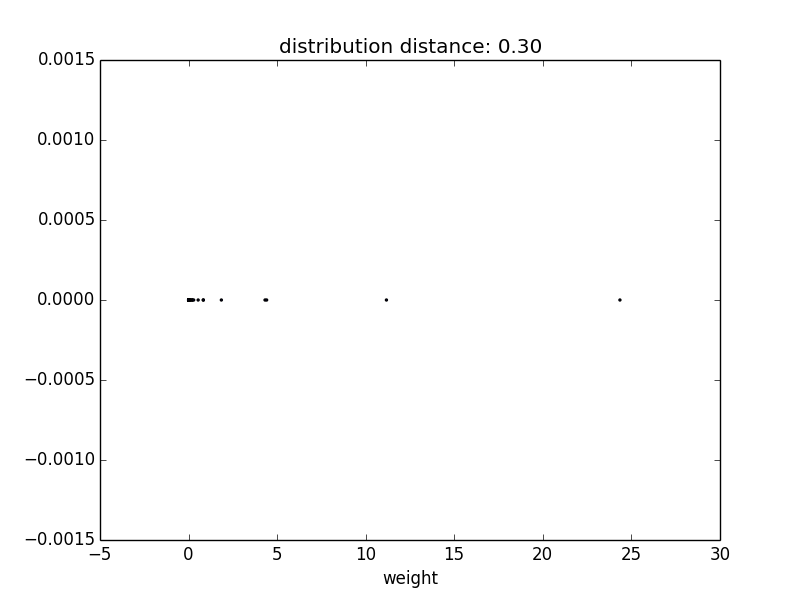

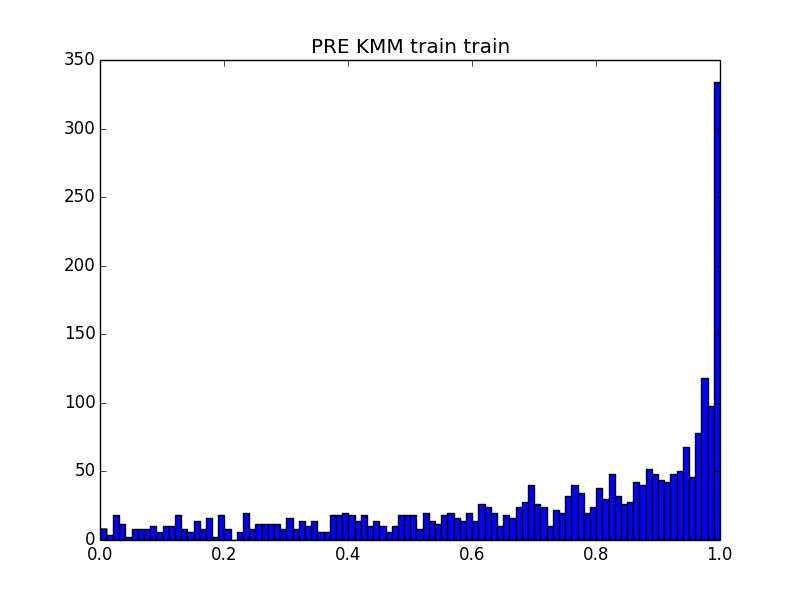

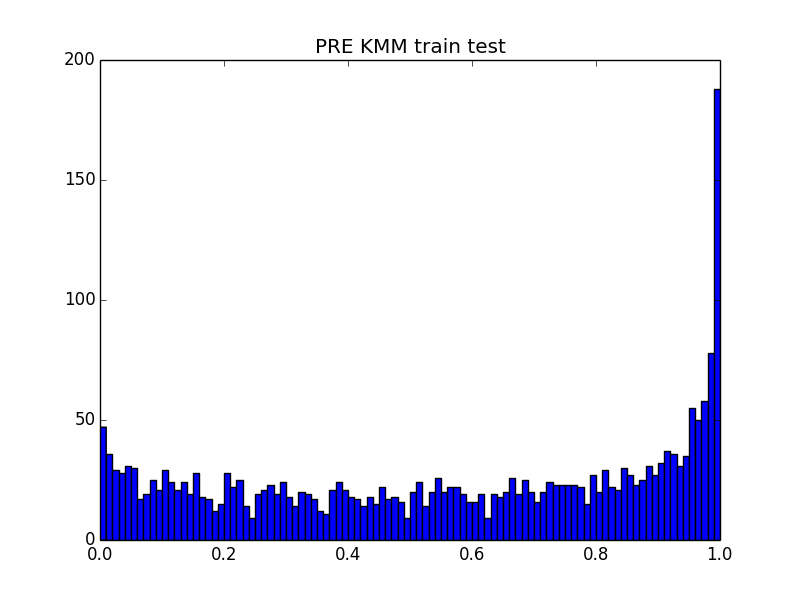

num_tight: 0
solver error: 0.0181306215208
num_tight: 0
solver error: 0.00670679710807
num_tight: 0
solver error: 0.00096563189802
num_tight: 0
solver error: 0.000690296069073
num_tight: 0
solver error: 0.000579760456894
num_tight: 0
solver error: 0.000522484428515
num_tight: 0
solver error: 0.000504211140994
num_tight: 0
solver error: 0.000503858119841
num_tight: 0
solver error: 0.000503828678878
num_tight: 0
solver error: 0.000503820974679
num_tight: 0
solver error: 0.000503814519664
num_tight: 0
solver error: 0.000503812809813
num_tight: 0
solver error: 0.000503813028204
num_tight: 0
solver error: 0.000503812682849
num_tight: 0
solver error: 0.000503812607248


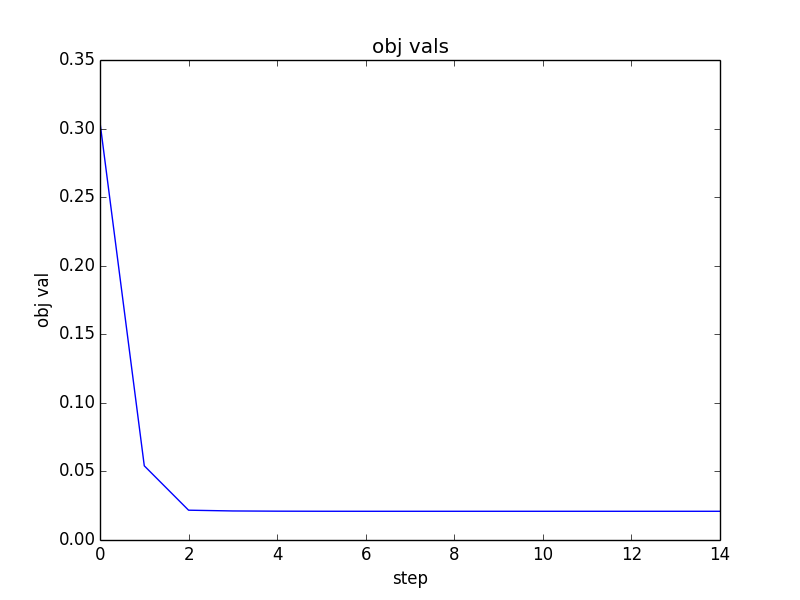

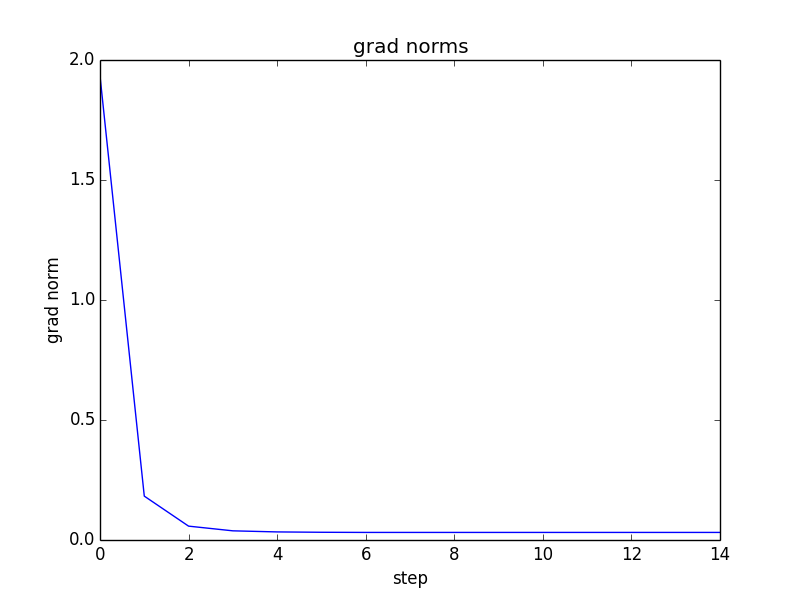

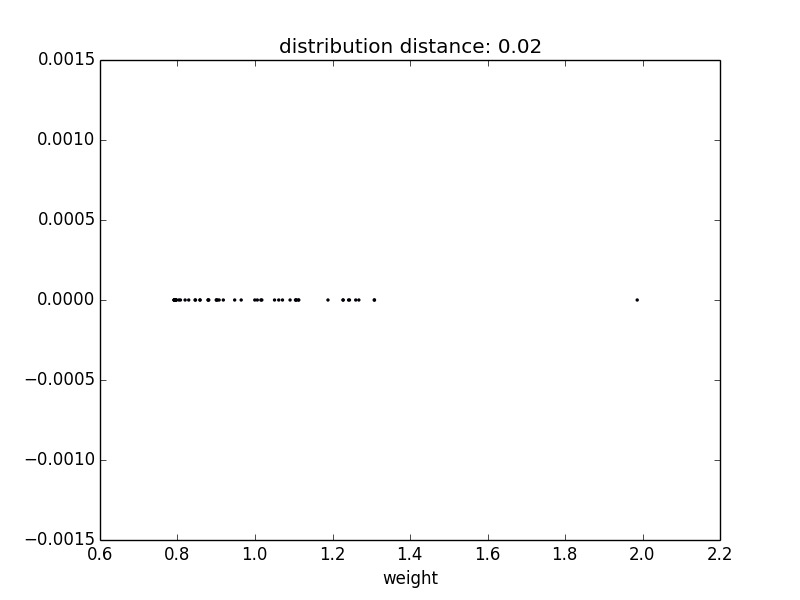

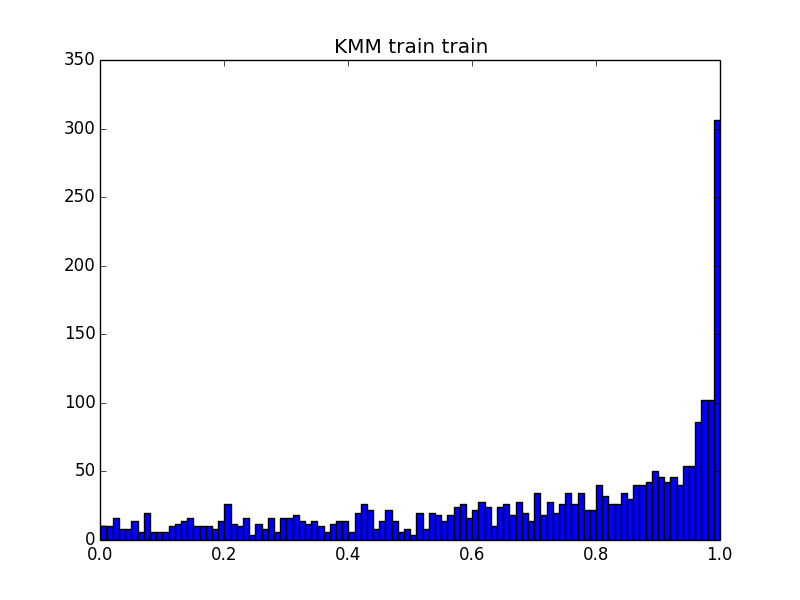

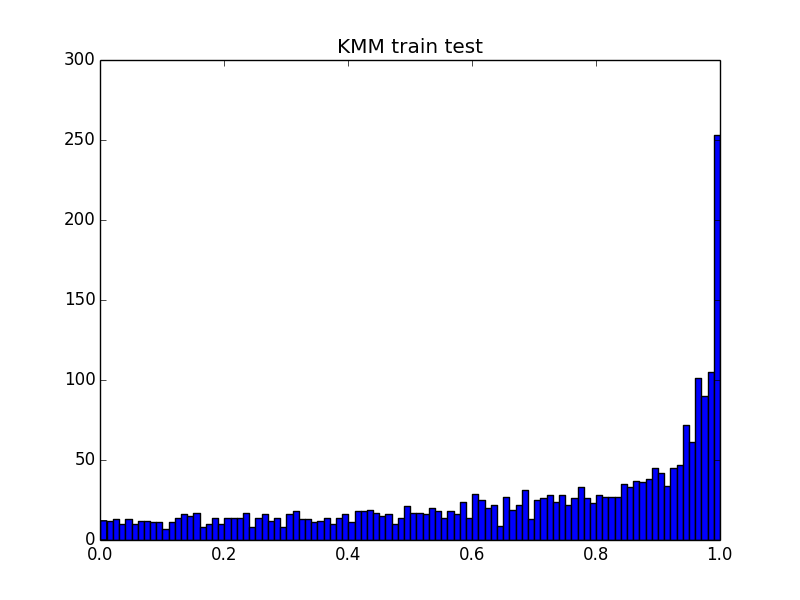

numerical gradient:
[[ 312.008348  ]
 [ 311.98935904]]
analytical gradient:
num_tight: 0
solver error: 0.000503812605189
[[-0.03157721]
 [ 0.00037077]]


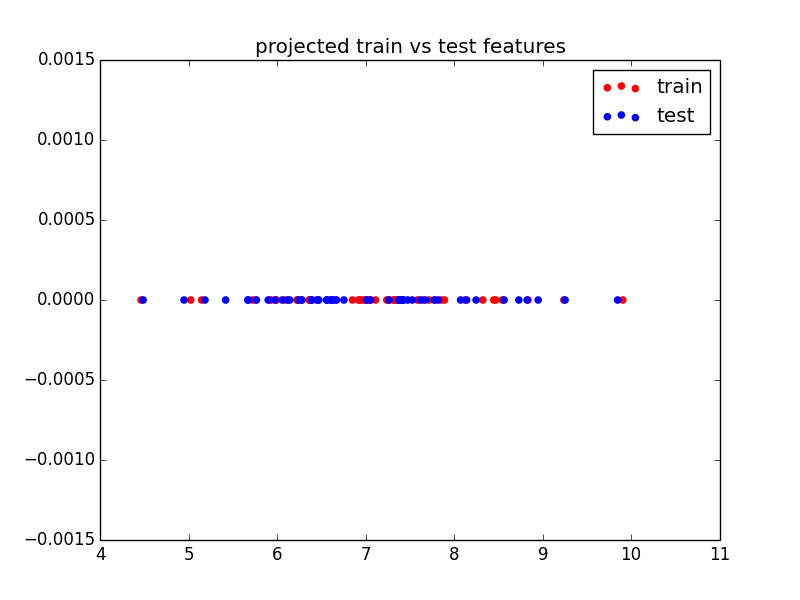

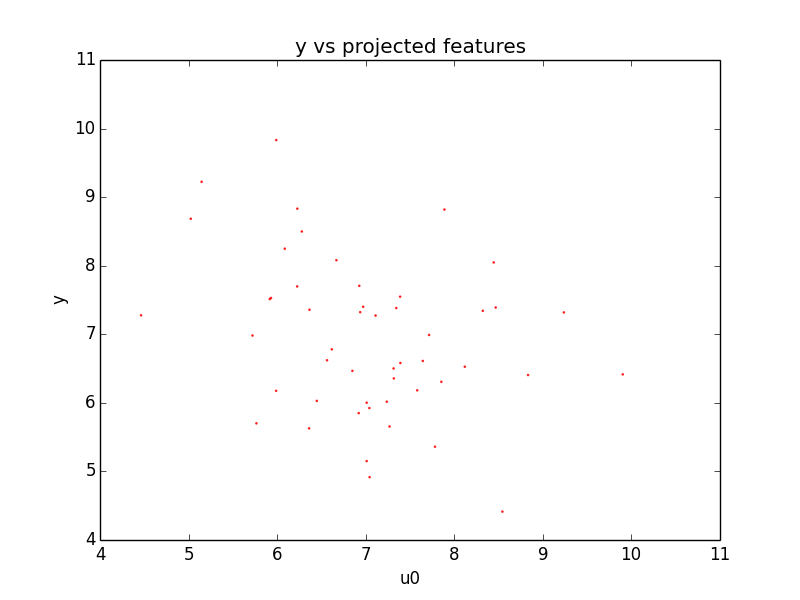

annealing step P: [[ 0.00775445]
 [ 0.99996993]]


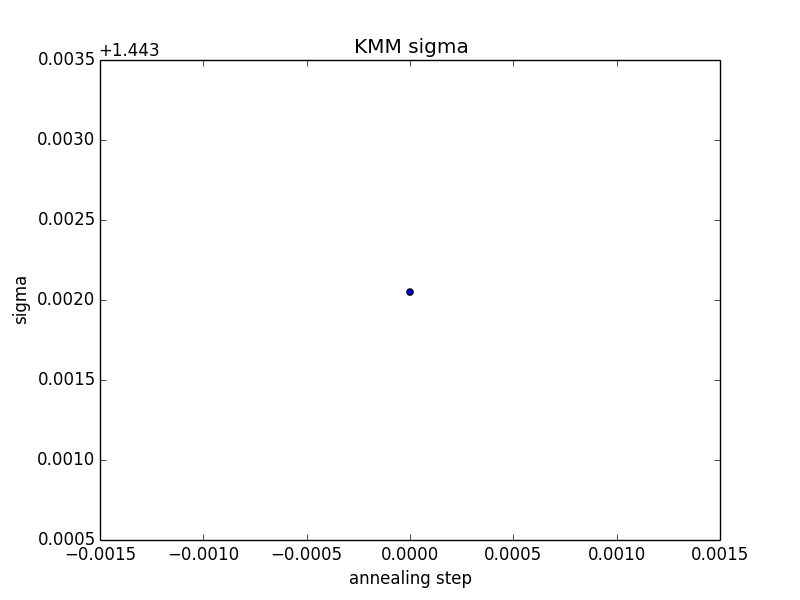

(array([[ 0.00775445],
        [ 0.99996993]]),
 (0.020936057857574825,
  [(<functools.partial at 0x11f6642b8>,
    array([[ 0.00775445],
           [ 0.99996993]]),
    {'final_values': {'f(x)': 0.020936057857574825,
      'gradnorm': 0.031579135456963607,
      'iterations': 15,
      'stepsize': 2.8735048710512962e-11,
      'time': 1.6682891845703125,
      'x': array([[ 0.00775445],
             [ 0.99996993]])},
     'iterations': {'f(x)': [0.30444017435081239,
       0.054084545999479157,
       0.021730576938327965,
       0.021175772584012272,
       0.02101722188527844,
       0.020956374906102887,
       0.020936496192068076,
       0.020936106162746951,
       0.020936075575208418,
       0.020936065984545459,
       0.020936059969103298,
       0.020936058083112708,
       0.020936057935248668,
       0.020936057888914981,
       0.020936057859877285],
      'gradnorm': [1.9335055119869791,
       0.18283860613924641,
       0.057752917458924843,
       0.03820650685814466

In [32]:
# run
annealer(P_init)

In [33]:
assert False

AssertionError: 